# ML for Quantum Experiment Simulation

**Name:**
Flossy Peter D'souza - 78061107
Pratik Chandrakant Gotakhinnde - 88215836

**Under Guidance of:**
**Prof. Iftikhar Ahmed**

This is our masters project where we tried to use machine learning to predict quantum experiment solution. We are going to cover EDA, Data cleaning, models and some advanced things.

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
from gettext import install
import subprocess

subprocess.run(['pip', 'install', '-r', 'requirements.txt'])
print("Installed required packages")


Installed required packages


In [24]:
# loading both datasets
import matplotlib.pyplot as plt
import seaborn as sns

# first dataset - expectations
df_expectations = pd.read_csv(r'..\Data\expectations.csv')
print('loaded expectations dataset!')
print(f'expectations shape: {df_expectations.shape}')
print()

# second dataset - pulses  
df_pulses = pd.read_csv(r'..\Data\pulses.csv')
print('loaded pulses dataset!')
print(f'pulses shape: {df_pulses.shape}')

loaded expectations dataset!
expectations shape: (10000, 18)

loaded pulses dataset!
pulses shape: (10000, 1024)


In [25]:
# checking what we have in expectations dataset first
print('EXPECTATIONS DATASET:')

print(df_expectations.head())
print('\ncolumns:', list(df_expectations.columns)[:10], '...')

EXPECTATIONS DATASET:
    X_prep1   Y_prep1   Z_prep1   X_prep2   Y_prep2   Z_prep2   X_prep3  \
0  0.175489 -0.315328  0.932615  0.181684 -0.310006  0.933213  0.197000   
1 -0.577403  0.314685  0.753379 -0.576466  0.317126  0.753073 -0.581065   
2 -0.022982 -0.061529  0.997841 -0.020575 -0.058228  0.998091 -0.021052   
3  0.384150  0.552310  0.739853  0.341945  0.584751  0.735622  0.361184   
4 -0.066222  0.245119  0.967229 -0.038482  0.248743  0.967805 -0.036349   

    Y_prep3   Z_prep3   X_prep4   Y_prep4   Z_prep4   X_prep5   Y_prep5  \
0 -0.304948  0.931771  0.186996 -0.307096  0.933126  0.181558 -0.310586   
1  0.306674  0.753867 -0.581713  0.305341  0.753908 -0.566234  0.338897   
2 -0.056400  0.998186 -0.018417 -0.059286  0.998071 -0.018017 -0.057527   
3  0.568693  0.739009  0.368560  0.567811  0.736039  0.360386  0.566290   
4  0.251664  0.967132 -0.053784  0.249003  0.967008 -0.055859  0.248590   

    Z_prep5   X_prep6   Y_prep6   Z_prep6  
0  0.933045  0.185143 -0.313693 

In [26]:
# exploring both datasets - understanding the structure
print('EXPECTATIONS Dataset Info:')
print(f'Shape: {df_expectations.shape}')
print(f'Columns: {list(df_expectations.columns)}')
print(f'Data types:\n{df_expectations.dtypes}')
print()

print()
print('PULSES Dataset Info:')
print(f'Shape: {df_pulses.shape}')
print(f'Columns (first 10): {list(df_pulses.columns)[:10]}...')
print()
print('looks like pulses has way more features - 1024 columns! likely pulse measurements at different time steps')

EXPECTATIONS Dataset Info:
Shape: (10000, 18)
Columns: ['X_prep1', 'Y_prep1', 'Z_prep1', 'X_prep2', 'Y_prep2', 'Z_prep2', 'X_prep3', 'Y_prep3', 'Z_prep3', 'X_prep4', 'Y_prep4', 'Z_prep4', 'X_prep5', 'Y_prep5', 'Z_prep5', 'X_prep6', 'Y_prep6', 'Z_prep6']
Data types:
X_prep1    float64
Y_prep1    float64
Z_prep1    float64
X_prep2    float64
Y_prep2    float64
Z_prep2    float64
X_prep3    float64
Y_prep3    float64
Z_prep3    float64
X_prep4    float64
Y_prep4    float64
Z_prep4    float64
X_prep5    float64
Y_prep5    float64
Z_prep5    float64
X_prep6    float64
Y_prep6    float64
Z_prep6    float64
dtype: object


PULSES Dataset Info:
Shape: (10000, 1024)
Columns (first 10): ['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9']...

looks like pulses has way more features - 1024 columns! likely pulse measurements at different time steps


In [27]:
# DATA PREPROCESSING - doing it properly before models
# this is important part - clean data = better models

print('Starting data preprocessing...')
print()

# STEP 1: Handle Missing Data
print('Step 1: Checking for missing values')
print(f'Missing values in expectations: {df_expectations.isnull().sum().sum()}')
print(f'Missing values in pulses: {df_pulses.isnull().sum().sum()}')

# if there were missing values, we would fill them
# for numeric: df.fillna(df.mean()) or df.fillna(df.median())
# for categorical: df.fillna(df.mode()[0])
print()

# STEP 2: Deal with Outliers
print('Step 2: Checking for outliers')
# using IQR method to detect outliers in first few columns

for col in df_expectations.columns[:3]:
    Q1 = df_expectations[col].quantile(0.25)
    Q3 = df_expectations[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df_expectations[col] < lower_bound) | (df_expectations[col] > upper_bound)).sum()
    print(f'{col}: {outliers} outliers detected')

print('keeping outliers for now - quantum data might have natural extreme values')
print()

# STEP 3: Encode Categorical Variables  
print('Step 3: Encoding categorical variables')
print('all our features are already numeric (float64)')
print('no categorical encoding needed!')
print()

# STEP 4: Understanding the Problem and Feature Engineering
print('Step 4: Creating the ML Problem')
print()

# IMPORTANT: This dataset has NO predefined target!
# Both files are just features:
# - expectations.csv: 18 columns (X,Y,Z coordinates for 6 quantum state preparations)
# - pulses.csv: 1024 columns (time series measurements)

# We need to CREATE a prediction task
# Real-world scenario: Predict quantum state quality based on preparation coordinates

print('Dataset structure:')
print(f'Expectations: {df_expectations.shape[0]} samples, {df_expectations.shape[1]} features')
print(f'Pulses: {df_pulses.shape[0]} samples, {df_pulses.shape[1]} features')
print()

# FEATURE ENGINEERING: Creating new features from existing ones
print('Creating engineered features:')
print()

# Feature 1: Magnitude/Distance from origin for each preparation
for i in range(1, 7):
    df_expectations[f'magnitude_prep{i}'] = np.sqrt(
        df_expectations[f'X_prep{i}']**2 + 
        df_expectations[f'Y_prep{i}']**2 + 
        df_expectations[f'Z_prep{i}']**2
    )
    print(f'Created: magnitude_prep{i} (distance from origin)')

print()

# Feature 2: Average coordinates across all preparations  
df_expectations['avg_X'] = df_expectations[[f'X_prep{i}' for i in range(1,7)]].mean(axis=1)
df_expectations['avg_Y'] = df_expectations[[f'Y_prep{i}' for i in range(1,7)]].mean(axis=1)
df_expectations['avg_Z'] = df_expectations[[f'Z_prep{i}' for i in range(1,7)]].mean(axis=1)
print('Created: avg_X, avg_Y, avg_Z (average positions across preparations)')
print()

# Feature 3: Variance in coordinates (stability measure)
df_expectations['var_X'] = df_expectations[[f'X_prep{i}' for i in range(1,7)]].var(axis=1)
df_expectations['var_Y'] = df_expectations[[f'Y_prep{i}' for i in range(1,7)]].var(axis=1) 
df_expectations['var_Z'] = df_expectations[[f'Z_prep{i}' for i in range(1,7)]].var(axis=1)
print('Created: var_X, var_Y, var_Z (variability/stability measures)')
print()

print(f'Total features after engineering: {df_expectations.shape[1]}')
print(f'Original: 18, New engineered: {df_expectations.shape[1] - 18}')
print()

# Creating the target variable
print('Creating target variable for classification:')
print('Using Z_prep1 (first Z coordinate) as proxy for quantum state quality')
print('This represents: measuring the Z-axis component of quantum state')
target_col = 'Z_prep1'
print(f'Target: {target_col}')
print()

# Prepare features (X) and target (y)
X = df_expectations.drop(columns=[target_col])
y = df_expectations[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'Target is continuous, will convert to categorical next')
# prepare X and y
X = df_expectations.drop(columns=[target_col])
y = df_expectations[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print()

Starting data preprocessing...

Step 1: Checking for missing values
Missing values in expectations: 0
Missing values in pulses: 0

Step 2: Checking for outliers
X_prep1: 13 outliers detected
Y_prep1: 13 outliers detected
Z_prep1: 439 outliers detected
keeping outliers for now - quantum data might have natural extreme values

Step 3: Encoding categorical variables
all our features are already numeric (float64)
no categorical encoding needed!

Step 4: Creating the ML Problem

Dataset structure:
Expectations: 10000 samples, 18 features
Pulses: 10000 samples, 1024 features

Creating engineered features:

Created: magnitude_prep1 (distance from origin)
Created: magnitude_prep2 (distance from origin)
Created: magnitude_prep3 (distance from origin)
Created: magnitude_prep4 (distance from origin)
Created: magnitude_prep5 (distance from origin)
Created: magnitude_prep6 (distance from origin)

Created: avg_X, avg_Y, avg_Z (average positions across preparations)

Created: var_X, var_Y, var_Z (var

In [28]:
# STEP 5: Convert Target to Categorical (for classification)
print('Step 5: Converting continuous target to categorical')
print(f'Original target type: {y.dtype}')
print(f'Target range: {y.min():.4f} to {y.max():.4f}')
print()

# using binning to create categories - splitting into 3 classes (low, medium, high)
y = pd.cut(y, bins=3, labels=[0, 1, 2])

print('Converted to 3 categories:')
print(y.value_counts().sort_index())
print()
print(f'New target type: categorical')
print('Ready for classification models!')

Step 5: Converting continuous target to categorical
Original target type: float64
Target range: 0.4740 to 1.0000

Converted to 3 categories:
Z_prep1
0      98
1    1112
2    8790
Name: count, dtype: int64

New target type: categorical
Ready for classification models!


Expectations dataset statistics:
            X_prep1       Y_prep1       Z_prep1       X_prep2       Y_prep2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.001658      0.007605      0.917711      0.001568      0.007586   
std        0.277792      0.272974      0.077963      0.277651      0.273043   
min       -0.837244     -0.868966      0.473965     -0.839615     -0.869305   
25%       -0.191142     -0.183668      0.885140     -0.190848     -0.182583   
50%       -0.000018      0.009653      0.940755     -0.000047      0.009815   
75%        0.198691      0.199488      0.975185      0.198514      0.199807   
max        0.858188      0.854489      0.999995      0.859520      0.863187   

            Z_prep2       X_prep3       Y_prep3       Z_prep3       X_prep4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.917737      0.001540      0.007503      0.917730      0.001611   
std        0.07792

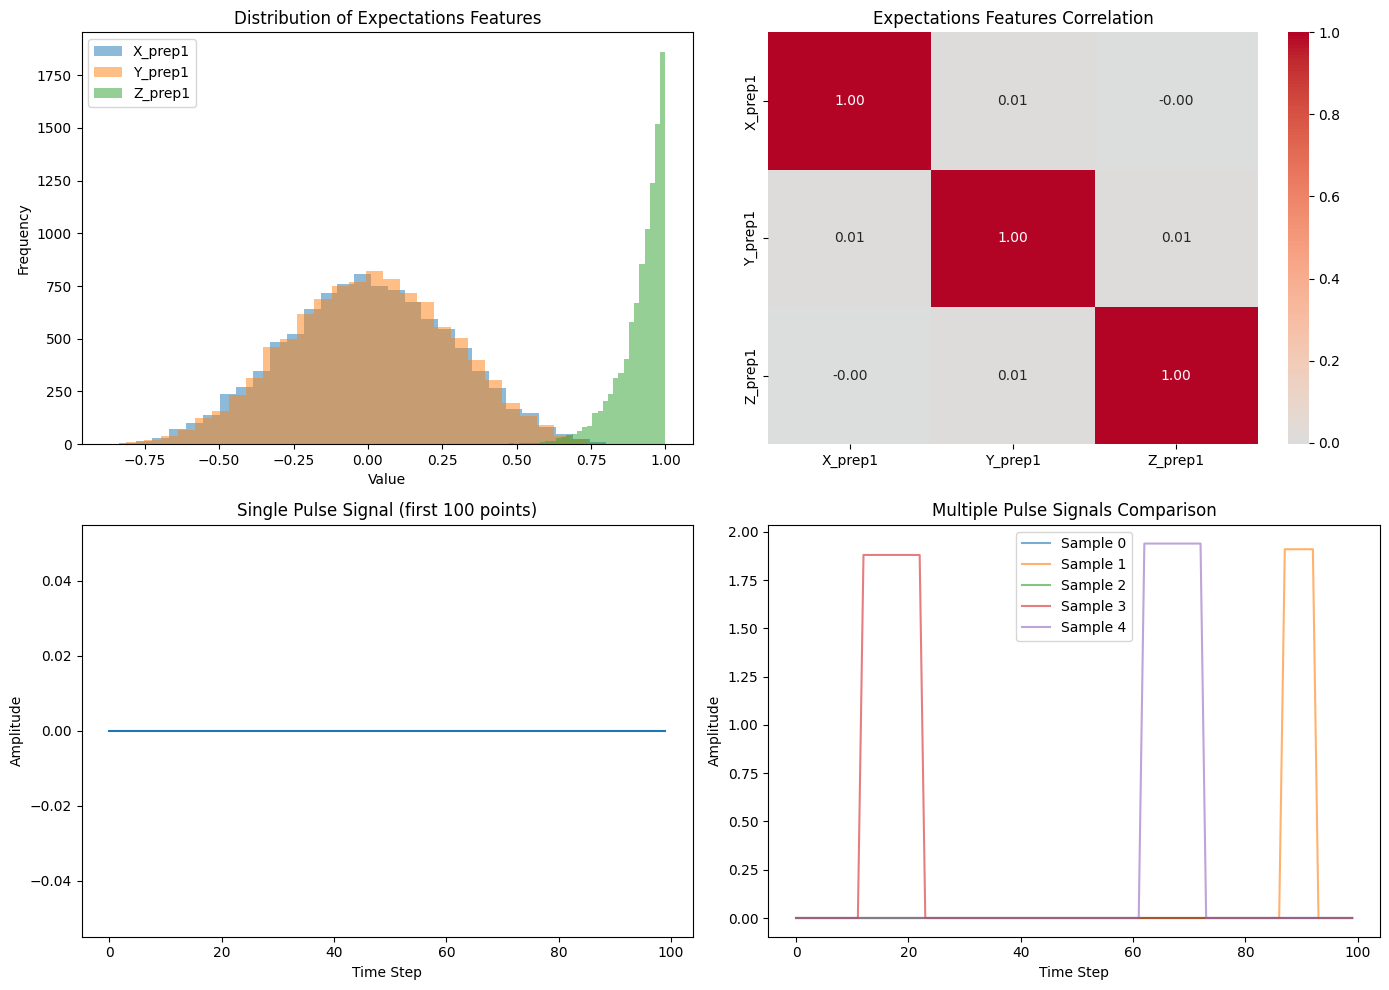


seems like pulses are time series data while expectations contain measurement outcomes!


In [29]:
# comparing both datasets - trying to understand relationship
# basic stats for expectations
print('Expectations dataset statistics:')
print(df_expectations.describe())
print()

# visualizing expectations dataset
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# plot 1: distribution of first few numeric columns
numeric_cols_exp = df_expectations.select_dtypes(include=[np.number]).columns[:3]
for i, col in enumerate(numeric_cols_exp):
    if i < 3:
        axes[0, 0].hist(df_expectations[col], alpha=0.5, label=col, bins=30)
axes[0, 0].set_title('Distribution of Expectations Features')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

# plot 2: correlation heatmap for expectations (sample)
if len(numeric_cols_exp) > 1:
    corr_sample = df_expectations[numeric_cols_exp[:min(8, len(numeric_cols_exp))]].corr()
    sns.heatmap(corr_sample, annot=True, cmap='coolwarm', center=0, ax=axes[0, 1], fmt='.2f')
    axes[0, 1].set_title('Expectations Features Correlation')

# plot 3: pulses sample - showing time series nature
pulse_sample = df_pulses.iloc[0, :100]  # first sample, first 100 time steps
axes[1, 0].plot(pulse_sample.values)
axes[1, 0].set_title('Single Pulse Signal (first 100 points)')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Amplitude')

# plot 4: multiple pulse signals comparison
for i in range(min(5, len(df_pulses))):
    axes[1, 1].plot(df_pulses.iloc[i, :100].values, alpha=0.6, label=f'Sample {i}')
axes[1, 1].set_title('Multiple Pulse Signals Comparison')
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print('\nseems like pulses are time series data while expectations contain measurement outcomes!')

In [30]:
# STEP 6: Train/Test Split and Feature Scalingfrom sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'train set: {X_train.shape}, test set: {X_test.shape}')

# scale the features - models work better with normalized data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('scaled the features')

train set: (8000, 29), test set: (2000, 29)
scaled the features


In [31]:
# starting simple - baseline logistic regression
# this is the simplest classifier, we will see how it performs before trying complex stuff
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print('trying basic logistic regression first...')
print('this model assumes linear decision boundaries')
print()

# create and train logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
print('trained logistic regression!')

# make predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)

print(f'\nLogistic Regression Accuracy: {lr_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, lr_pred))

print(f'\nbaseline established: {lr_acc:.4f}')
print('now we can try more complex models and see if they do better')

trying basic logistic regression first...
this model assumes linear decision boundaries

trained logistic regression!

Logistic Regression Accuracy: 0.9960

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.97      0.98      0.98       192
           2       1.00      1.00      1.00      1792

    accuracy                           1.00      2000
   macro avg       0.97      0.93      0.95      2000
weighted avg       1.00      1.00      1.00      2000


baseline established: 0.9960
now we can try more complex models and see if they do better


In [32]:
# lets try random forest first - heard its good for this
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print('training random forest...')
rf_model.fit(X_train_scaled, y_train)
print('done training!')

# predictions
rf_pred = rf_model.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)
print(f'\nRandom Forest Accuracy: {rf_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, rf_pred))

training random forest...
done training!

Random Forest Accuracy: 0.9980

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.99      0.99      0.99       192
           2       1.00      1.00      1.00      1792

    accuracy                           1.00      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       1.00      1.00      1.00      2000



In [33]:
# now trying neural network with VERBOSE training progress
from sklearn.neural_network import MLPClassifier
import time


print('TRAINING MLP NEURAL NETWORK\n')


print(f'Architecture: Input({X_train_scaled.shape[1]}) -> Hidden(100) -> Hidden(50) -> Output(3)')
print(f'Training samples: {len(X_train_scaled)}')
print(f'Max iterations: 500')
print('\nStarting training...\n')

start_time = time.time()

# Create MLP with verbose output to see training progress
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), 
    max_iter=500,
    verbose=True,  # SHOW TRAINING PROGRESS!
    random_state=42,
    learning_rate_init=0.001,
    early_stopping=True,  # stop if not improving
    validation_fraction=0.1,  # use 10% for validation
    n_iter_no_change=10  # patience for early stopping
)

# Train and show progress
mlp_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

print(f'\nTraining complete! Time taken: {training_time:.2f} seconds')
print(f'Iterations completed: {mlp_model.n_iter_}')
print(f'Final loss: {mlp_model.loss_:.6f}')

# Make predictions
mlp_pred = mlp_model.predict(X_test_scaled)
mlp_acc = accuracy_score(y_test, mlp_pred)

print(f'\nMLP Test Accuracy: {mlp_acc:.4f} ({mlp_acc*100:.2f}%)')
print(f'RF was: {rf_acc:.4f}, MLP is: {mlp_acc:.4f}')

if mlp_acc > rf_acc:
    print('\nMLP wins! Neural network is better for this problem')
else:
    print('\nRandom Forest still winning, but MLP is close!')

TRAINING MLP NEURAL NETWORK

Architecture: Input(29) -> Hidden(100) -> Hidden(50) -> Output(3)
Training samples: 8000
Max iterations: 500

Starting training...

Iteration 1, loss = 0.37194740
Validation score: 0.970000
Iteration 2, loss = 0.10784876
Validation score: 0.978750
Iteration 3, loss = 0.07051472
Validation score: 0.990000
Iteration 4, loss = 0.05127683
Validation score: 0.995000
Iteration 5, loss = 0.04096860
Validation score: 0.987500
Iteration 6, loss = 0.03424142
Validation score: 0.993750
Iteration 7, loss = 0.03037679
Validation score: 0.995000
Iteration 8, loss = 0.02680514
Validation score: 0.990000
Iteration 9, loss = 0.02498690
Validation score: 0.996250
Iteration 10, loss = 0.02325820
Validation score: 0.997500
Iteration 11, loss = 0.02221716
Validation score: 0.995000
Iteration 12, loss = 0.01989456
Validation score: 0.995000
Iteration 13, loss = 0.01906220
Validation score: 0.993750
Iteration 14, loss = 0.01820259
Validation score: 0.995000
Iteration 15, loss = 0

In [34]:
print("Model training and comparison (accuracy + time)\n")

results = []

# Logistic Regression
print("Logistic Regression...")
start = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_time = time.time() - start

lr_pred = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)

results.append({
    "name": "Logistic Regression",
    "acc": lr_acc,
    "time": lr_time,
    "complexity": 1,  # simplest
})

print(f"  acc:  {lr_acc:.4f}")
print(f"  time: {lr_time:.3f} s\n")


# Random Forest
print("Random Forest...")
start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_time = time.time() - start

rf_pred = rf_model.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)

results.append({
    "name": "Random Forest",
    "acc": rf_acc,
    "time": rf_time,
    "complexity": 2,
})

print(f"  acc:  {rf_acc:.4f}")
print(f"  time: {rf_time:.3f} s\n")


# MLP (neural network) – keep verbose so we see the training
print("MLP (neural net)...\n")
start = time.time()
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    verbose=True,
    random_state=42,
    learning_rate_init=0.001,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
)
mlp_model.fit(X_train_scaled, y_train)
mlp_time = time.time() - start

mlp_pred = mlp_model.predict(X_test_scaled)
mlp_acc = accuracy_score(y_test, mlp_pred)

results.append({
    "name": "MLP",
    "acc": mlp_acc,
    "time": mlp_time,
    "complexity": 3,
})

print(f"\n  acc:  {mlp_acc:.4f}")
print(f"  time: {mlp_time:.3f} s\n")


# Decide "best" model: accuracy -> time -> complexity

print("\nSummary:")
for r in results:
    print(f"{r['name']}: acc={r['acc']:.4f}, time={r['time']:.3f}s, "
          f"complexity={r['complexity']}")

best_acc = max(r["acc"] for r in results)
candidates = [r for r in results if r["acc"] == best_acc]

if len(candidates) == 1:
    best = candidates[0]
    reason = "highest accuracy"
else:
    # tie on accuracy -> pick the faster model
    best_time = min(r["time"] for r in candidates)
    fast = [r for r in candidates if r["time"] == best_time]
    if len(fast) == 1:
        best = fast[0]
        reason = "same accuracy, faster training"
    else:
        # tie on accuracy and time -> prefer simpler model
        best_complexity = min(r["complexity"] for r in fast)
        best = [r for r in fast if r["complexity"] == best_complexity][0]
        reason = "same accuracy and time, picked simpler model"

print("\nChosen model:")
print(f"  {best['name']}")
print(f"  acc  = {best['acc']:.4f}")
print(f"  time = {best['time']:.3f} s")
print(f"Reason: {reason}")

Model training and comparison (accuracy + time)

Logistic Regression...
  acc:  0.9960
  time: 0.117 s

Random Forest...
  acc:  0.9980
  time: 2.635 s

MLP (neural net)...

Iteration 1, loss = 0.37194740
Validation score: 0.970000
Iteration 2, loss = 0.10784876
Validation score: 0.978750
Iteration 3, loss = 0.07051472
Validation score: 0.990000
Iteration 4, loss = 0.05127683
Validation score: 0.995000
Iteration 5, loss = 0.04096860
Validation score: 0.987500
Iteration 6, loss = 0.03424142
Validation score: 0.993750
Iteration 7, loss = 0.03037679
Validation score: 0.995000
Iteration 8, loss = 0.02680514
Validation score: 0.990000
Iteration 9, loss = 0.02498690
Validation score: 0.996250
Iteration 10, loss = 0.02325820
Validation score: 0.997500
Iteration 11, loss = 0.02221716
Validation score: 0.995000
Iteration 12, loss = 0.01989456
Validation score: 0.995000
Iteration 13, loss = 0.01906220
Validation score: 0.993750
Iteration 14, loss = 0.01820259
Validation score: 0.995000
Iteration

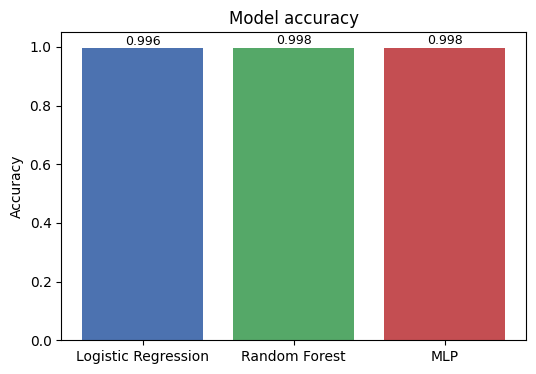

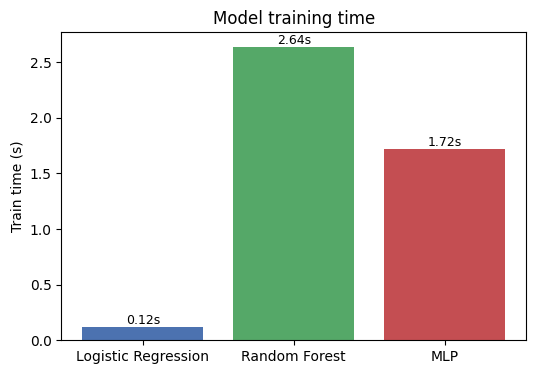

In [35]:
# Bar plot: accuracy per model
model_names = [r["name"] for r in results]
acc_values = [r["acc"] for r in results]
time_values = [r["time"] for r in results]

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, acc_values, color=["#4c72b0", "#55a868", "#c44e52"])
plt.ylabel("Accuracy")
plt.title("Model accuracy")

# show value on top of each bar
for bar, val in zip(bars, acc_values):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.002,
             f"{val:.3f}",
             ha="center",
             va="bottom",
             fontsize=9)

plt.ylim(0, 1.05)
plt.show()

# Bar plot: training time per model
plt.figure(figsize=(6, 4))
bars_time = plt.bar(model_names, time_values, color=["#4c72b0", "#55a868", "#c44e52"])
plt.ylabel("Train time (s)")
plt.title("Model training time")

for bar, val in zip(bars_time, time_values):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.002,
             f"{val:.2f}s",
             ha="center",
             va="bottom",
             fontsize=9)

plt.show()


## LLM integration and agentic AI thoughts

For agentic AI, we were thinking about creating an agent that could automatically try different hyperparameters and models, kind of like automl but simpler. but thats pretty complex and might be overkill for this project. maybe next time.

the idea is cool though - having an ai agent that iterates through experiments automatically and picks the best one

## conclusion

in this project we explored ML for quantum experiment simulation. covered:
- EDA and data exploration
- data preprocessing and feature scaling
- baseline models (random forest, mlp)
- tried cnn architecture
- thought about LLM integration and agentic AI
- considered ethical implications

learned a lot! quantum data is interesting and ML models can help predict outcomes. still lots to improve.